### Retrieving the street network and sampling it

Sampling the network allows to determine points where calculations will be made or where street view images will be obtained for analysis. 

Exported: data/network.geojson


<Axes: >

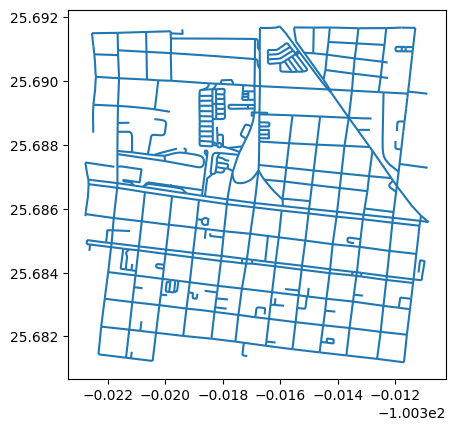

In [5]:
from alivestreets.network import network_retrieval, osm_features
from alivestreets.sampling.street_sampler import StreetSampler
import geopandas as gpd

lat = 25.6865415470827
lon = -100.31682261963644
radius = 600

graph = network_retrieval.get_graph_from_point(lat, lon, radius)
network_path = "data/network.geojson"
network_retrieval.export_graph_geojson(graph, network_path)

gdf = gpd.read_file(network_path)
gdf.plot()


In [2]:
from alivestreets.network import osm_features

lat = 25.6865415470827
lon = -100.31682261963644
radius = 600

osm_features.export_all_from_point("data/features", lat, lon, radius)

No features found for PlaceType.PARKS: No matching features. Check query location, tags, and log.
Exported data/features/amenities.geojson
Exported data/features/bus_stops.geojson
Exported data/features/schools.geojson
Exported data/features/job_centers.geojson
No features found for PlaceType.INSTITUTIONS: No matching features. Check query location, tags, and log.
Exported data/features/homes.geojson
No features found for PlaceType.CENSUS_BLOCK: No matching features. Check query location, tags, and log.
Exported data/features/subway.geojson


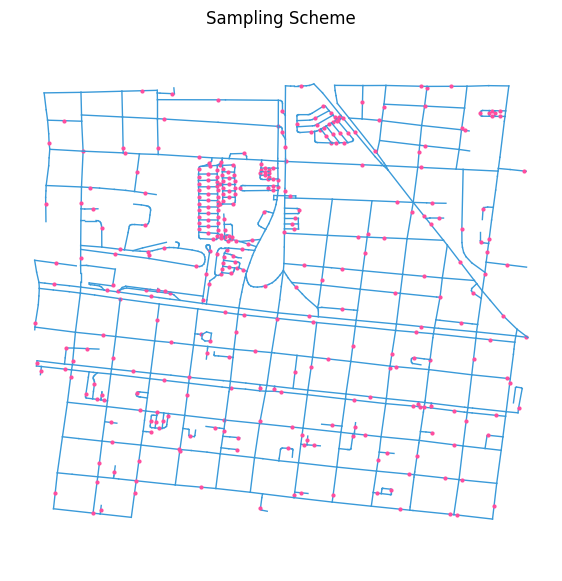

In [4]:
from alivestreets.sampling.street_sampler import StreetSampler

# Create a StreetSampler with a maximum number of sampling points
sampler = StreetSampler(max_points=200)

# Load the exported network
sampler.open_streets("data/network.geojson")

# Sample the streets
sampler.sample_streets_no_intersections()

# Optional: draw sampling scheme
sampler.draw_sampling_scheme(width=7, height=7, node_size = 2)


In [ ]:
#Let's tag the network with accessibility, for simplicity let's simply do the distance to the nearest amenity at each point. 
#Then to tag that distance for a street we will 